# Traitement des données Plateau de fromage 2017

In [2]:
import sys
sys.version

'3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]'

In [3]:
import pandas as pd
import numpy as np

# 1) Formatage des données brutes de terrain pour Distance 6.2

## Chargement des données brutes

In [4]:
dfToutBrut = pd.read_excel('PlateauFromages-JPM2017.xlsx')

In [5]:
dfToutBrut.rename(columns={'MÂLE (O)' : 'MALE', 'Juvénile (O) ' : 'JUVENILE'}, inplace=True)

In [6]:
dfToutBrut.dtypes

POINT                  object
ESPECE                 object
DISTANCE              float64
MALE                   object
JUVENILE               object
OBSERVATEUR            object
DATE           datetime64[ns]
dtype: object

In [10]:
dfToutBrut.columns

Index(['POINT', 'ESPECE', 'DISTANCE', 'MALE', 'JUVENILE', 'OBSERVATEUR',
       'DATE'],
      dtype='object')

In [11]:
dfToutBrut.ESPECE.unique()

array(['COLPAL', 'CUCCAN', 'ANTTRI', 'PRUMOD', 'PHOPHO', 'TURMER',
       'SYLATR', 'SYLBOR', 'SYLCOM', 'PHYCOL', 'PARMAJ', 'LANCOL',
       'FRICOE', 'CARCHL', 'EMBCIT', 'ERIRUB', 'TURPHI', 'LOPCRI',
       'CYACAE', 'GARGLA', 'CORCOR', 'LULARB', 'SAXTOR', 'TURVIS',
       'HIPPOL', 'CERBRA', 'ALAARV', 'STUVUL', 'STRDEC', 'PHOOCH',
       'REGIGN', 'PASDOM', 'PASMON', 'SERSER', 'CARCAR', 'MOTALB',
       'TROTRO', 'PICPIC', 'PERATE', 'HIRRUS', 'CARCAN', 'BUTBUT',
       'MOTCIN', 'CORMON', 'REGREG', 'PICVIR'], dtype=object)

In [13]:
## Examen rapide des données brutes

In [14]:
len(dfToutBrut)

438

In [15]:
# Nb de mâles adultes.
len(dfToutBrut[dfToutBrut.MALE.notnull()])

318

In [16]:
# Nb d'adultes non identifié comme mâle (femelle ou ... sexe ou age non identifié).
len(dfToutBrut[dfToutBrut.MALE.isnull() & dfToutBrut.JUVENILE.isnull()])

86

In [17]:
# Nb de juvéniles.
len(dfToutBrut[dfToutBrut.JUVENILE.notnull()])

34

## Redressement booléen des colonnes Mâle et Juvéniles

In [18]:
def toBool(s):
    return False if pd.isnull(s) or (type(s) is str and s.lower() != 'o') else True

dfToutBrut.MALE = dfToutBrut.MALE.apply(toBool)
dfToutBrut.JUVENILE = dfToutBrut.JUVENILE.apply(toBool)
dfToutBrut.head()

,POINT,ESPECE,DISTANCE,MALE,JUVENILE,OBSERVATEUR,DATE
0,70B,COLPAL,376.190476,True,False,JPM,2017-05-21
1,70B,CUCCAN,523.809524,True,False,JPM,2017-05-21
2,70B,ANTTRI,146.666667,True,False,JPM,2017-05-21
3,70B,ANTTRI,177.142857,True,False,JPM,2017-05-21
4,70B,PRUMOD,200.000000,True,False,JPM,2017-05-21


## Vérifications erreurs, incohérences ...

In [19]:
# Pas de lignes avec Mâle ET Juvénile
assert not (dfToutBrut.MALE & dfToutBrut.JUVENILE).any(), 'Attention : Au moins 1 ligne Mâle _et_ Juvénile'

## Séparation des données mâles seuls et non-juvéniles (on ignore les juvéniles)

In [21]:
dfMalesBrut = dfToutBrut[dfToutBrut.MALE == True][['POINT', 'ESPECE', 'DISTANCE', 'MALE', 'OBSERVATEUR', 'DATE']]
dfMalesBrut.rename(columns={'MALE' : 'NOMBRE'}, inplace=True)
dfMalesBrut.NOMBRE = 1
dfMalesBrut.head()

,POINT,ESPECE,DISTANCE,NOMBRE,OBSERVATEUR,DATE
0,70B,COLPAL,376.190476,1,JPM,2017-05-21
1,70B,CUCCAN,523.809524,1,JPM,2017-05-21
2,70B,ANTTRI,146.666667,1,JPM,2017-05-21
3,70B,ANTTRI,177.142857,1,JPM,2017-05-21
4,70B,PRUMOD,200.000000,1,JPM,2017-05-21


In [22]:
len(dfMalesBrut)

318

In [23]:
dfNonJuvBrut = dfToutBrut[dfToutBrut.JUVENILE == False][['POINT', 'ESPECE', 'DISTANCE', 'MALE', 'OBSERVATEUR', 'DATE']]
dfNonJuvBrut.rename(columns={'MALE' : 'NOMBRE'}, inplace=True)
dfNonJuvBrut.NOMBRE = 1
dfNonJuvBrut.head()

,POINT,ESPECE,DISTANCE,NOMBRE,OBSERVATEUR,DATE
0,70B,COLPAL,376.190476,1,JPM,2017-05-21
1,70B,CUCCAN,523.809524,1,JPM,2017-05-21
2,70B,ANTTRI,146.666667,1,JPM,2017-05-21
3,70B,ANTTRI,177.142857,1,JPM,2017-05-21
4,70B,PRUMOD,200.000000,1,JPM,2017-05-21


In [24]:
len(dfNonJuvBrut)

404

## Ajout des lignes d'absence

In [31]:
# Ensemble complet des espèces d'intérêt (= contactées, puisqu'elles ont probablement toutes été contactées)
# NB: Cette méthode d'obtention est fiable, même si elle n'en a pas l'air (espèces sans aucune donnée 2017 ? pas crédible)
stEspeces = set(dfToutBrut.ESPECE.unique())
print('{' + ', '.join(stEspeces) + '}')

{CARCAN, LULARB, TURVIS, PRUMOD, TURPHI, BUTBUT, CARCAR, PICVIR, SAXTOR, GARGLA, SYLBOR, HIPPOL, SYLCOM, ALAARV, PASMON, TROTRO, HIRRUS, LOPCRI, PERATE, PHYCOL, STUVUL, ERIRUB, CERBRA, CORCOR, SYLATR, CYACAE, CORMON, COLPAL, PICPIC, PHOPHO, TURMER, LANCOL, REGREG, PARMAJ, SERSER, EMBCIT, PASDOM, MOTALB, PHOOCH, FRICOE, ANTTRI, CARCHL, STRDEC, CUCCAN, MOTCIN, REGIGN}


### Choix Mâles ou Non-juvéniles

(exécuter l'une des 2 cellules suivantes, et une seule)

In [32]:
dfSelectionBrute = dfMalesBrut

In [53]:
dfSelectionBrute = dfNonJuvBrut

### Espèces contactées par point

In [54]:
dfEspecesContactees = dfSelectionBrute.groupby(['POINT', 'ESPECE']).first().reset_index()[['POINT', 'ESPECE']]
dfEspecesContactees.head()

,POINT,ESPECE
0,33B,ALAARV
1,33B,ANTTRI
2,33B,CORCOR
3,33B,EMBCIT
4,33B,FRICOE


### Infos observateur et date pour chaque point

In [55]:
dfInfosPoint = dfSelectionBrute[['POINT', 'OBSERVATEUR', 'DATE', 'ESPECE']] \
               .groupby(['POINT', 'OBSERVATEUR', 'DATE']).count().reset_index().set_index('POINT').drop('ESPECE', axis=1)
dfInfosPoint.head()

,OBSERVATEUR,DATE
POINT,,
33B,JPM,2017-06-05
43B,JPM,2017-06-05
44B,JPM,2017-06-05
45A,JPM,2017-06-05
54B,JPM,2017-06-05


In [56]:
# Vérification que pas de doublons, sinon, le join qui suit ne peut plus s'appliquer
assert len(dfInfosPoint) == len(dfSelectionBrute.POINT.unique()), \
       'Erreur : Des points non recensés le même jour et par le même observateur'

### Especes non contactées par point

(=> un set d'espèces pour chaque point)

In [57]:
dfEspecesManquees = dfEspecesContactees.groupby('POINT').agg(lambda df: stEspeces - set(df.ESPECE.unique()))
dfEspecesManquees.head()

,ESPECE
POINT,
33B,"{CARCAN, TURVIS, PRUMOD, BUTBUT, CARCAR, PICVI..."
43B,"{CARCAN, TURVIS, LULARB, PRUMOD, TURPHI, BUTBU..."
44B,"{CARCAN, TURVIS, PICVIR, PRUMOD, BUTBUT, CARCA..."
45A,"{CARCAN, BUTBUT, PRUMOD, TURPHI, CARCAR, SAXTO..."
54B,"{TURVIS, PICVIR, PRUMOD, TURPHI, LULARB, BUTBU..."


In [58]:
# Ajout des infos observateur et date à chaque point
dfEspecesManquees = dfEspecesManquees.join(dfInfosPoint)
dfEspecesManquees.head()

,ESPECE,OBSERVATEUR,DATE
POINT,,,
33B,"{CARCAN, TURVIS, PRUMOD, BUTBUT, CARCAR, PICVI...",JPM,2017-06-05
43B,"{CARCAN, TURVIS, LULARB, PRUMOD, TURPHI, BUTBU...",JPM,2017-06-05
44B,"{CARCAN, TURVIS, PICVIR, PRUMOD, BUTBUT, CARCA...",JPM,2017-06-05
45A,"{CARCAN, BUTBUT, PRUMOD, TURPHI, CARCAR, SAXTO...",JPM,2017-06-05
54B,"{TURVIS, PICVIR, PRUMOD, TURPHI, LULARB, BUTBU...",JPM,2017-06-05


### Génération des données d'absence

In [59]:
dfSelectionAbsence = pd.DataFrame(columns=dfSelectionBrute.columns,
                                  data=[(nomPoint, espece, np.nan, 0, point.OBSERVATEUR, point.DATE) \
                                       for nomPoint, point in dfEspecesManquees.iterrows() for espece in point.ESPECE])
dfSelectionAbsence.head()

,POINT,ESPECE,DISTANCE,NOMBRE,OBSERVATEUR,DATE
0,33B,CARCAN,NaN,0,JPM,2017-06-05
1,33B,TURVIS,NaN,0,JPM,2017-06-05
2,33B,PRUMOD,NaN,0,JPM,2017-06-05
3,33B,BUTBUT,NaN,0,JPM,2017-06-05
4,33B,CARCAR,NaN,0,JPM,2017-06-05


In [60]:
len(dfSelectionAbsence)

559

In [61]:
len(dfSelectionBrute)

404

In [62]:
# Vérification rudimentaire en nombre d'espèces
assert len(dfSelectionAbsence) \
       == len(stEspeces) * len(dfInfosPoint) - len(dfSelectionBrute.groupby(['POINT', 'ESPECE']).first()), \
       "Erreur dans calcul données d'absence"

### Tableau final : données de contact et d'absence.

In [63]:
dfSelectionTotale = dfSelectionBrute.append(dfSelectionAbsence).sort_values(by=['POINT', 'ESPECE']) \
                    .reset_index().drop('index', axis=1)
dfSelectionTotale.head()

,POINT,ESPECE,DISTANCE,NOMBRE,OBSERVATEUR,DATE
0,33B,ALAARV,142.857143,1,JPM,2017-06-05
1,33B,ANTTRI,139.682540,1,JPM,2017-06-05
2,33B,ANTTRI,307.936508,1,JPM,2017-06-05
3,33B,BUTBUT,NaN,0,JPM,2017-06-05
4,33B,CARCAN,NaN,0,JPM,2017-06-05


In [64]:
len(dfSelectionTotale)

963

In [65]:
# Vérification rudimentaire en nombre d'espèces (inutile : o a confiance dans l'append ...)
assert len(dfSelectionTotale.groupby(['POINT', 'ESPECE']).first()) == len(stEspeces) * len(dfInfosPoint), \
       "Erreur dans génération finale"

## Export Excel

### Choix Mâles ou Non-juvéniles

(exécuter l'une des 2 cellules suivantes, et une seule)

In [52]:
dfMales = dfSelectionTotale

In [66]:
dfNonJuvs = dfSelectionTotale

### Export => 1 classeur à 2 feuilles : mâles et tout (sauf juvs).

In [71]:
xlsWriter = pd.ExcelWriter('PlateauFromages2017-PourDistance.xlsx', datetime_format='DD/MM/YYYY')
dfMales.to_excel(xlsWriter, 'Mâles', index=False, float_format='%.1f')
dfNonJuvs.to_excel(xlsWriter, 'NonJuvs', index=False, float_format='%.1f')
xlsWriter.save()

# 2) Graphiques

In [142]:
%matplotlib inline

In [73]:
import matplotlib.pyplot as plt # graphiques
import matplotlib.dates as pltd # dates
import matplotlib.patches as pltp

# Données par observateur

In [159]:
del dfToutBrutNb

In [175]:
# Donnees bidon pour tests avec plusieurs observateurs.
dfToutBrutBidon = dfToutBrut[['OBSERVATEUR', 'MALE', 'JUVENILE', 'ESPECE']].copy()
dfToutBrutBidon2 = dfToutBrutBidon.copy()
dfToutBrutBidon2.OBSERVATEUR = 'GSS'
dfToutBrutBidon = dfToutBrutBidon.append(dfToutBrutBidon2)
del dfToutBrutBidon2

dfToutBrutNbIndiv = dfToutBrutBidon[['OBSERVATEUR', 'MALE', 'JUVENILE']].copy()
dfToutBrutNbEsp = dfToutBrutBidon[['OBSERVATEUR', 'ESPECE']].copy()
del dfToutBrutBidon

In [167]:
# Données réelles.
dfToutBrutNbIndiv = dfToutBrut[['OBSERVATEUR', 'MALE', 'JUVENILE']].copy()
dfToutBrutNbEsp = dfToutBrut[['OBSERVATEUR', 'ESPECE']].copy()

In [181]:
# Nb individus contactés
dfToutBrutNbIndiv['NOMBRE'] = dfToutBrutNbIndiv.apply(lambda s: (1 if s.MALE else 0) + (1 if s.JUVENILE else 0), axis=1)
dfToutBrutNbIndiv.drop(['MALE', 'JUVENILE'], axis=1, inplace=True)
dfToutBrutNbIndiv = dfToutBrutNbIndiv.groupby('OBSERVATEUR').sum()
dfToutBrutNbIndiv

,NOMBRE
OBSERVATEUR,
GSS,352
JPM,352


In [182]:
# Nb espèces contactées
dfToutBrutNbEsp = dfToutBrutNbEsp.reset_index().groupby(['OBSERVATEUR', 'ESPECE']).first().reset_index() \
                  .drop('index', axis=1).groupby('OBSERVATEUR').count()
dfToutBrutNbEsp

ValueError: labels ['index'] not contained in axis

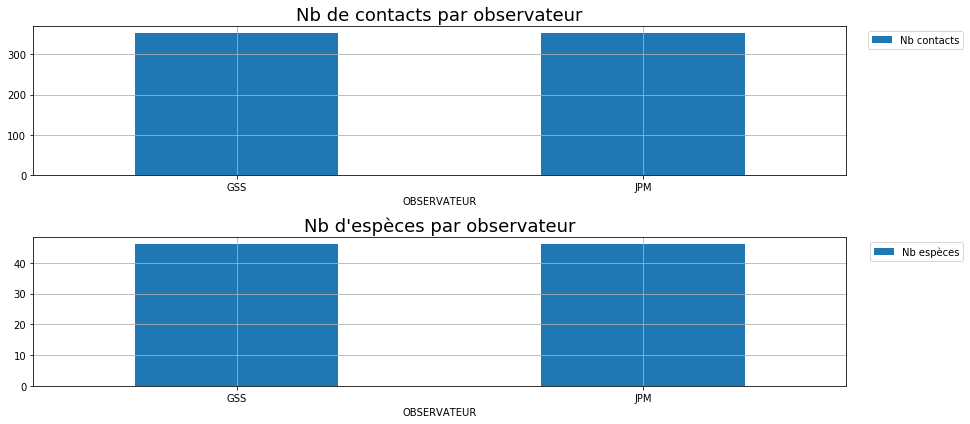

In [184]:
fig = plt.figure(figsize=(12, 6))
#fig.suptitle('Stats observateur', fontsize=18, y=1.00)

axes = fig.add_subplot(2, 1, 1)
dfToutBrutNbIndiv.plot(kind='bar', ax=axes)
axes.legend(['Nb contacts'], bbox_to_anchor=[1.15, 1.0], fontsize=10)
axes.grid(True)
#plt.ylim(0, 120)
axes.set_title('Nb de contacts par observateur', fontsize=18)
axes.set_xticklabels(dfToutBrutNbIndiv.index, rotation=0)

axes = fig.add_subplot(2, 1, 2)
dfToutBrutNbEsp.plot(kind='bar', ax=axes)
axes.legend(['Nb espèces'], bbox_to_anchor=[1.15, 1.0], fontsize=10)
axes.grid(True)
#plt.ylim(0, 120)
axes.set_title("Nb d'espèces par observateur", fontsize=18)
axes.set_xticklabels(dfToutBrutNbEsp.index, rotation=0)

fig.tight_layout()